Imagem a detectar Waldo


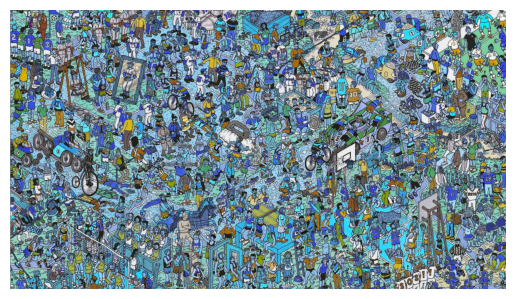

Imagem original com dimensão aumentada


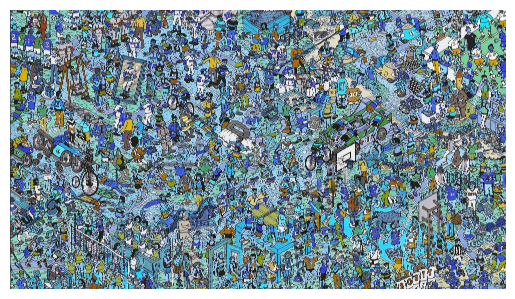

Imagem em escala de cinza


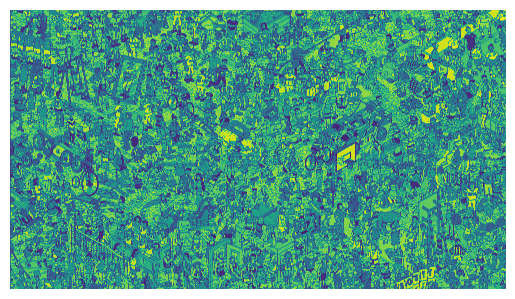

Imagem em escala de cinza suavizada


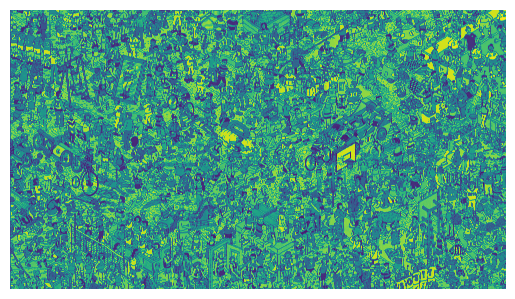

Imagem que manteve somente pixels pretos


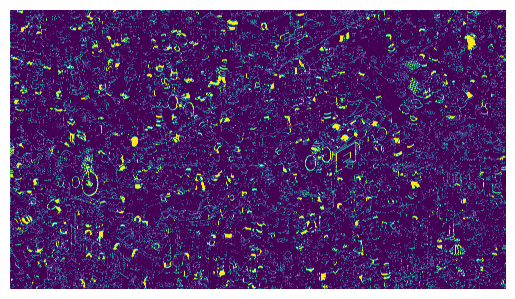

Imagem com bordas do objeto


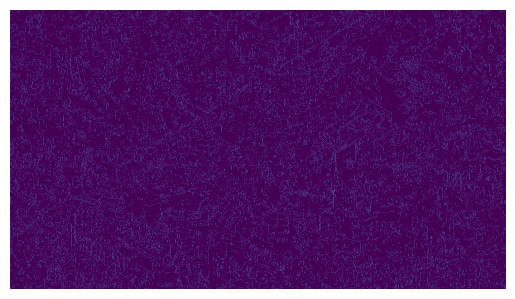

Encontrando círculos na imagem...
Círculos encontrados.
Filtrando círculos com potencial para serem as lentes do óculos de Waldo...


C:\Users\Brenno\AppData\Local\Temp\ipykernel_6308\601541064.py:108: RuntimeWarning: overflow encountered in scalar subtract
  if 20 < dist < 50 and abs(centro1[1] - centro2[1]) <= limite_alinhamento_horizontal: # Distância mínima e máxima entre as lentes dos óculos e verificação de alinhamento horizontal


Círculos com potencial para serem as lentes encontrados.
Verificando qual par de círculos melhor representa os óculos de Waldo...
Waldo potencialmente encontrado.
Isolando Waldo na imagem...


Imagem com Waldo detectado


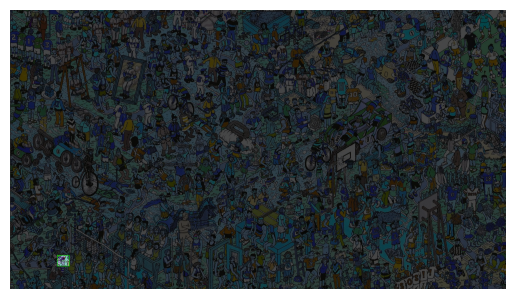

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint

PATH_DA_IMAGEM = 'waldo-5.jpg'

# Função para imprimir a imagem
def exibe_imagem(imagem):
    plt.imshow(imagem)
    plt.axis('off')
    plt.show()

# Função para encontrar o quadrado que contenha os dois círculos
def encontrar_quadrado(circulo1, circulo2):
    x_min = min(abs(circulo1[0] - circulo1[2]), abs(circulo2[0] - circulo2[2]))
    x_max = max(abs(circulo1[0] + circulo1[2]), abs(circulo2[0] + circulo2[2]))
    y_min = min(abs(circulo1[1] - circulo1[2]), abs(circulo2[1] - circulo2[2]))
    y_max = max(abs(circulo1[1] + circulo1[2]), abs(circulo2[1] + circulo2[2]))
    return (x_min, y_min, x_max, y_max)

# Função para contar a proporção de pixels brancos dentro de um quadrado em uma imagem preto e branco
def contar_proporcao_pixels_brancos(imagem_bw, x_min, y_min, x_max, y_max):
    roi = imagem_bw[y_min:y_max, x_min:x_max]
    pixels_brancos = cv2.countNonZero(roi)
    total_pixels = roi.size
    proporcao_brancos = (pixels_brancos / total_pixels) if total_pixels > 0 else 0
    return proporcao_brancos

# Função para contar a proporção de pixels pretos dentro de um quadrado em uma imagem preto e branco
def contar_proporcao_pixels_pretos(imagem_bw, x_min, y_min, x_max, y_max):
    roi = imagem_bw[y_min:y_max, x_min:x_max]
    pixels_pretos = np.sum(roi == 0)
    total_pixels = roi.size
    proporcao_pretos = (pixels_pretos / total_pixels) if total_pixels > 0 else 0
    return proporcao_pretos

# Função para calcular a distância euclidiana entre dois centros de círculos
def calcular_distancia(centro1, centro2):
    centro1 = np.array(centro1, dtype=np.float64)
    centro2 = np.array(centro2, dtype=np.float64)
    return np.linalg.norm(centro1 - centro2)

# Função para detectar Waldo em uma imagem
def encontrar_waldo(imagem):
    
    # Aumenta a dimensão da imagem
    escala = 8
    imagem_grande = cv2.resize(imagem, None, fx=escala, fy=escala, interpolation=cv2.INTER_CUBIC)
    print('Imagem original com dimensão aumentada')
    exibe_imagem(imagem_grande)

    # Converter para escala de cinza
    imagem_cinza = cv2.cvtColor(imagem_grande, cv2.COLOR_BGRA2GRAY)
    print('Imagem em escala de cinza')
    cv2.imwrite('resultados/imagem_cinza.jpg', imagem_cinza)
    exibe_imagem(imagem_cinza)

    # Aplicar suavização GaussianBlur
    imagem_suavizada = cv2.GaussianBlur(imagem_cinza, (9, 9), 2)
    print('Imagem em escala de cinza suavizada')
    cv2.imwrite('resultados/imagem_suavizada.jpg', imagem_suavizada)
    exibe_imagem(imagem_suavizada)
    
    # Converter para preto e branco
    kernel = np.ones((5,5),np.uint8)
    imagem_preto_e_branco = cv2.threshold(imagem_cinza,40,255,cv2.THRESH_BINARY_INV)[1]
    imagem_preto_e_branco = cv2.morphologyEx(imagem_preto_e_branco, cv2.MORPH_CLOSE, kernel)
    print('Imagem que manteve somente pixels pretos')
    cv2.imwrite('resultados/imagem_preto_e_branco.jpg', imagem_preto_e_branco)
    exibe_imagem(imagem_preto_e_branco)

    # Detectr bordas usando Canny
    # Propósito é simular como a transformada de Hough verá as bordas do objeto. Só possui utilidade para debug.
    imagem_bordas = cv2.Canny(imagem_preto_e_branco, 100, 200)
    print('Imagem com bordas do objeto')
    cv2.imwrite('resultados/imagem_bordas.jpg', imagem_bordas)
    exibe_imagem(imagem_bordas)

    # Utilizar a transformada de Hough para encontrar círculos
    print('Encontrando círculos na imagem...')
    circulos = cv2.HoughCircles(imagem_suavizada, cv2.HOUGH_GRADIENT, dp=1.3, minDist=5,
                                param1=200, param2=20, minRadius=15, maxRadius=25)
    print('Círculos encontrados.')

    # Filtragem dos círculos detectados
    if circulos is not None:
        circulos = np.uint16(np.around(circulos))
        pares_de_oculos = []
        melhor_par = None
        max_pixels_brancos = 0
        max_pixels_pretos = 0
        melhor_quadrado = None

        # Encontrar pares de círculos próximos, com o intuito de achar as lentes dos óculos de Waldo
        print('Filtrando círculos com potencial para serem as lentes do óculos de Waldo...')
        for i in range(len(circulos[0])):
            for j in range(i + 1, len(circulos[0])):
                centro1 = (circulos[0][i][0], circulos[0][i][1])
                centro2 = (circulos[0][j][0], circulos[0][j][1])
                
                dist = calcular_distancia(centro1, centro2)

                 # Limite para considerar círculos alinhados horizontalmente (ajustar conforme necessário)
                limite_alinhamento_horizontal = 10
                
                if 20 < dist < 50 and abs(centro1[1] - centro2[1]) <= limite_alinhamento_horizontal: # Distância mínima e máxima entre as lentes dos óculos e verificação de alinhamento horizontal
                    pares_de_oculos.append((circulos[0][i], circulos[0][j]))
                    
        print('Círculos com potencial para serem as lentes encontrados.')
        
        # Verificar cada par de círculos
        print('Verificando qual par de círculos melhor representa os óculos de Waldo...')
        for par in pares_de_oculos:
            # Encontrar o quadrado que contenha ambos os círculos
            x_min, y_min, x_max, y_max = encontrar_quadrado(par[0], par[1])

            # DEBUG: Retirar as linhas abaixo no futuro, proósito delas é apenas exibir os circulos e os quadrados deles encontrados
            centro1, raio1 = par[0][:2], par[0][2]
            centro2, raio2 = par[1][:2], par[1][2]
            cv2.circle(imagem_grande, (centro1[0], centro1[1]), raio1, (0, 255, 0), 2)
            cv2.circle(imagem_grande, (centro1[0], centro1[1]), 2, (0, 255, 0), 3)
            cv2.circle(imagem_grande, (centro2[0], centro2[1]), raio2, (0, 255, 0), 2)
            cv2.circle(imagem_grande, (centro2[0], centro2[1]), 2, (0, 255, 0), 3)
            # cv2.rectangle(imagem_grande, (x_min - 100, y_min - 100), (x_max + 100, y_max + 100), (randint(0, 255), randint(0, 255), randint(0, 255)), 4)
   
            # Conta pixels brancos na região de interesse (quadrado)
            # A região de interesse é acima da lente dos óculos, objetivo é achar o cabelo do Waldo, que mantem uma grande concentração de pixels brancos na imagem preto e branco.
            total_pixels_brancos = contar_proporcao_pixels_brancos(imagem_preto_e_branco, x_min, y_min - 70, x_max, y_max - 60)

            # Conta pixels pretos na região de interesse (quadrado)
            # A região de interesse é um pouco acima da lente dos óculos, objetivo é achar a testa do Waldo, que mantem uma concentração de pixels pretos  na imagem preto e branco.
            total_pixels_pretos = contar_proporcao_pixels_pretos(imagem_preto_e_branco, x_min, y_max - 55, x_max, y_max - 50)

            cv2.rectangle(imagem_grande, (x_min, y_min - 70), (x_max, y_max - 60), (255, 0, 0), 4)
            cv2.rectangle(imagem_grande, (x_min, y_max - 55), (x_max, y_max - 50), (0, 0, 255), 4)
            
            # Verifica se este par tem mais pixels brancos
            if total_pixels_brancos > max_pixels_brancos and total_pixels_pretos > max_pixels_pretos:
                max_pixels_brancos = total_pixels_brancos
                max_pixels_pretos = total_pixels_pretos
                melhor_par = par
                melhor_quadrado = (x_min - 150, y_min - 150, x_max + 150, y_max + 150)

        # Desenha o melhor par de círculos na imagem original
        print('Waldo potencialmente encontrado.')
        print('Isolando Waldo na imagem...')
        if melhor_par:   
            # Desenha o quadrado de destaque
            x_min, y_min, x_max, y_max = melhor_quadrado
            cv2.rectangle(imagem_grande, (x_min, y_min), (x_max, y_max), (0, 255, 0), 20)

             # Cria uma máscara para escurecer a imagem fora do quadrado de destaque
            mask = np.zeros(imagem_grande.shape, dtype=np.uint8)
            mask[y_min:y_max, x_min:x_max] = imagem_grande[y_min:y_max, x_min:x_max]

            # Escurece a imagem
            imagem_escurecida = cv2.addWeighted(imagem_grande, 0.3, mask, 0.7, 0)

    try:
        return cv2.resize(imagem_escurecida, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    except Exception:
        print('Não foi possível encontrar o Waldo.')
        return undefined

# Carrega a imagem de entrada
imagem = cv2.imread(PATH_DA_IMAGEM)

print('Imagem a detectar Waldo')
exibe_imagem(imagem)

# Detecta o Waldo
imagem_com_waldo = encontrar_waldo(imagem)

# Mostra a imagem com a detecção
cv2.imwrite('resultados/waldo_detectado.jpg', imagem_com_waldo)
print('\n\nImagem com Waldo detectado')
exibe_imagem(imagem_com_waldo)